In [7]:
import random
import io
import base64
from collections import namedtuple
# https://numpy.org/
import numpy as np
# python image library https://pillow.readthedocs.io/en/stable/installation.html
from PIL import Image
# https://ipython.org/
from IPython import display

# display helper functions 

def blend_many(ims):
    """
    Blends a sequence of images
    """
    current, *ims = ims
    for i, im in enumerate(ims):
        current = Image.blend(current, im, 1 / (i + 2))
    return current

def blend_tiles(choices, tiles):
    """
    Given a list of states (True if ruled out, False if not) for each tiel, and a list of tiles, return a blend of all the tiles that have't been ruled out.
    """
    to_blend = [tiles[i].bitmap for i in range(len(choices)) if choices[i]]
    return blend_many(to_blend)

def show_state(potential, tiles):
    """
    Given a list of states for each tile for each position of the image, return
    an image representing the state of the global image.
    """
    rows = []
    for row in potential:
        rows.append([np.asarray(blend_tiles(t, tiles)) for t in row])

    rows = np.array(rows)
    n_rows, n_cols, tile_height, tile_width, _ = rows.shape
    images = np.swapaxes(rows, 1, 2)
    return Image.fromarray(images.reshape(n_rows*tile_height, n_cols*tile_width, 4))


def find_true(array):
    """
    Like np.nonzero, except it makes sense
    """
    transform = int if len(np.asarray(array).shape) == 1 else tuple
    return list(map(transform, np.transpose(np.nonzero(array))))

# assemble image
straight_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAMklEQVQYlWNQVrT9r6xo+988UfN/0yqN/4evOP0/fMXpf9Mqjf/miZr/YfIMowrpqxAAjKLGXfWE8ZAAAAAASUVORK5CYII=')))
bend_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAANklEQVQYlWNQVrT9TwxmIFmheaImXoyisGmVBk6MofDwFSesmHKFRFvdtEoDv2fQFWINHnwKAQHMxl1/fce/AAAAAElFTkSuQmCC')))
blank_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAFElEQVQYlWNQVrT9TwxmGFVIX4UAoDOWARI9hF0AAAAASUVORK5CYII=')))
cross_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAU0lEQVQYlWNQVrT9r6xo+988UfN/0yqN/4evOP0/fMXpf9Mqjf/miZr/YfIMRCs0T9T8D8PYFMIwQ9Mqjf/IGFkhMmaASRDCxCsk2mqiPUP1cAQAKI/idfPNuccAAAAASUVORK5CYII=')))
t_image = Image.open(io.BytesIO(base64.b64decode('iVBORw0KGgoAAAANSUhEUgAAAAoAAAAKCAYAAACNMs+9AAAAWUlEQVQYlWNQVrT9r6xo+988UfN/0yqN/4evOP0/fMXpf9Mqjf/miZr/YfIMRCs0T9T8D8PYFMIwQ9Mqjf/IGFkhMmaASRDCxCtEtwIXRvEMPgwPHkKYaIUAow/UaQFDAc4AAAAASUVORK5CYII=')))

# define which parts of the images have pipes that can be connected

Tile = namedtuple('Tile', ('name', 'bitmap', 'sides', 'weight'))

tiles = [
    Tile('straight_ud', straight_image,
         [False, True, False, True], 1/2),
    Tile('straight_lr', straight_image.transpose(Image.Transpose.ROTATE_90),
         [True, False, True, False], 1/2),
    Tile('bend_br', bend_image,
         [True, False, False, True], 1/4),
    Tile('bend_tr', bend_image.transpose(Image.Transpose.ROTATE_90),
         [True, True, False, False], 1/4),
    Tile('bend_tl', bend_image.transpose(Image.Transpose.ROTATE_180),
         [False, True, True, False], 1/4),
    Tile('bend_bl', bend_image.transpose(Image.Transpose.ROTATE_270),
         [False, False, True, True], 1/4),
    Tile('t_u', t_image,
         [True, True, True, False], 1/4),
    Tile('t_l', t_image.transpose(Image.Transpose.ROTATE_90),
         [False, True, True, True], 1/4),
    Tile('t_d', t_image.transpose(Image.Transpose.ROTATE_180),
         [True, False, True, True], 1/4),
    Tile('t_r', t_image.transpose(Image.Transpose.ROTATE_270),
         [True, True, False, True], 1/4),
    Tile('blank', blank_image,
         [False, False, False, False], 1),
    Tile('cross', cross_image,
         [True, True, True, True], 1)
]

# array of of weights for quick access
weights = np.asarray([t.weight for t in tiles])

# all values in matrix a True at first, and wieghts filter down possibilities
potential = np.full((30, 30, len(tiles)), True)

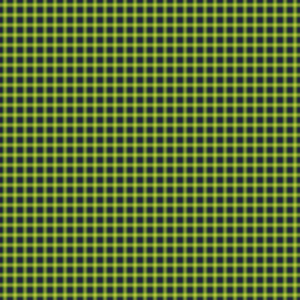

In [8]:
display.display(show_state(potential, tiles))

In [ ]:
def run_iteration(old_potential):
    potential = old_potential.copy()
    # 3 find the undecided location with the fewest remaining tiles
    to_collapse = location_with_fewest_choices(potential)
    # 1 if all locations are decided, we are done
    if to_collapse is None:
        raise StopIteration()
    # 2 if any location has no choices left, we have failed
    elif not np.any(potential[to_collapse]):
        raise Exception(f'no choices left at {to_collapse}')
    # 4 collapse step -- pick a tile at random among those that are still possible choices for this location. mark this tile as the only remaining possibility for this location
    else:
        nonzero = find_true(potential[to_collapse])
        tile_probs = weights[nonzero] / sum(weights[nonzero])
        selected_tile = np.random.choice(nonzero, p=tile_probs)
        potential[to_collapse] = False
        potential[to_collapse][selected_tile] = True
        # 5 propagation step -- this choise is likely to rule out some possible tiles at neighboring locations. we need to update our potential to reflect this
        propagate(potential, to_collapse)
        return potential